# Nima Beheshti
## nb9pp
### DS 5001 Final Project - Analyzing Historical Corpus of Political Texts

##### Most of this code, and many of the functions derived from or where taken from the course code walkthroughs, and homework assignments. I have indicated when a function was taken directly from the walkthroughs and homeworks but may have missed some along the way.

In [1]:
# Load Packages
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
from nltk.stem.porter import PorterStemmer
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import seaborn as sns
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import norm
import plotly_express as px
import seaborn as sns
from scipy.linalg import eigh as eig
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from gensim.models import word2vec
from sklearn.manifold import TSNE
from IPython.core.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sns.set(style="ticks")
%matplotlib inline

/Users/nimabeheshti/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Directory with book files
book_dir = 'project_books/'

In [3]:
book_id = ['5','61','1232','1404','2130','2162','3207','5669','6762','7370','17306']
book_start = []
book_end = []

In [4]:
# For loop to find the start and end points of the books
for i in book_id:
    file_name = book_dir + i + '.txt'
    file_read = open(file_name, 'r', encoding='utf-8-sig').readlines()
    df = pd.DataFrame(file_read, columns=['line_str'])
    df.index.name = 'line_num'
    df.line_str = df.line_str.str.strip()
    a = df.line_str.str.match(r"\*\*\*\s*START OF (THE|THIS) PROJECT")
    b = df.line_str.str.match(r"\*\*\*\s*END OF (THE|THIS) PROJECT")
    an = df.loc[a].index[0]
    bn = df.loc[b].index[0]
    dfa = df.loc[an + 1]
    dfb = df.loc[bn - 1]
    book_start.append(dfa)
    book_end.append(dfb)

In [5]:
id_start_end = pd.DataFrame(list(zip(book_id,book_start,book_end)), 
                            columns = ["book_id", 'start','end'])

In [6]:
id_start_end

book_id                                              start  \
0        5               line_str    
Name: 40, dtype: object   
1       61               line_str    
Name: 19, dtype: object   
2     1232               line_str    
Name: 26, dtype: object   
3     1404               line_str    
Name: 20, dtype: object   
4     2130               line_str    
Name: 26, dtype: object   
5     2162               line_str    
Name: 19, dtype: object   
6     3207               line_str    
Name: 24, dtype: object   
7     5669               line_str    
Name: 20, dtype: object   
8     6762               line_str    
Name: 21, dtype: object   
9     7370               line_str    
Name: 20, dtype: object   
10   17306  line_str    IN ENGLAND IN 1844***
Name: 29, dt...   

                                        end  
0     line_str    
Name: 680, dtype: object  
1    line_str    
Name: 1529, dtype: object  
2    line_str    
Name: 4828, dtype: object  
3   line_str    
Name: 19397, dtype: object  
4    line_str    
Name: 3688, dtype: object  
5    line_str    
Name: 7294, dtype: object  
6   line_str    
Name: 22648, dtype: object  
7    line_str    
Name: 8941, dtype: object  
8    line_str    
Name: 9743, dtype: object  
9    line_str    
Name: 5154, dtype: object  
10  line_str    
Name: 10998, dtype: object

In [7]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [8]:
# Function from walkthrough
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
chap_pats = {
    5: {
        'start_line': 40,
        'end_line': 680,
        'chapter': re.compile("^ARTICLE\s+{}$".format(roman))
    },
    61: {
        'start_line': 19,
        'end_line': 1529,
        'chapter': re.compile("^\s*Chapter\s+{}.*$".format(roman))
    },
    1232: {
        'start_line': 1000, # This was mannually found through trial and error becuase the previous start had issues
        'end_line': 4828,
        'chapter': re.compile("^\s*CHAPTER\s+{}\.".format(roman))
    },
    1404: {\
        'start_line': 20,
        'end_line': 19397,
        'chapter': re.compile("^\s*FEDERALIST No. +\d+$")
    },
    2130: {
        'start_line': 26,
        'end_line': 3688,
        'chapter': re.compile("^\s*CHAPTER\s+\d\.\s.*".format(roman))
    },
    2162: {
        'start_line': 19,
        'end_line': 7294,
        'chapter': re.compile("^\s*ESSAY\s+{}\.\s.*$".format(roman))
    },
    3207: {
        'start_line': 24,
        'end_line': 22648,
        'chapter': re.compile("^\s*CHAPTER\s+{}\.".format(roman))
    },
    5669: {
        'start_line': 20,
        'end_line': 8941, 
        'chapter': re.compile("^\s*Chapter\s+{}.*$".format(roman))          
    },
    6762: {
        'start_line': 21,
        'end_line': 9743,
        'volume': re.compile("^\s*BOOK\s+{}$".format(roman)),
        'chapter': re.compile("^\s*CHAPTER\s+{}$".format(roman))
    },
    7370: {
        'start_line': 20,
        'end_line': 5154,
        'volume': re.compile("^\s*Book\s+{}$".format(roman)),
        'chapter': re.compile("^\s*CHAPTER\.\s+{}\.$".format(roman))
    },
    17306: {
        'start_line': 30,
        'end_line': 10998,
        'chapter': re.compile("^\s*CHAPTER\s+{}\s.*$".format(roman))
    }  
}    

In [9]:
# Function from walkthrough
def acquire_epubs(book_list, chap_pats, OHCO=OHCO):
    
    my_lib = []
    my_doc = []

    for epub_file in book_list:
        
        # Get PG ID from filename
        book_id = int(epub_file.split('/')[-1].split('.')[0])
        
        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        df = pd.DataFrame(lines, columns=['line_str'])
        df.index.name = 'line_num'
        df.line_str = df.line_str.str.strip()
        df['book_id'] = book_id
        
        # FIX CHARACTERS TO IMPROVE TOKENIZATION
        df.line_str = df.line_str.str.replace('—', ' — ')
        df.line_str = df.line_str.str.replace('-', ' - ')
        
        # Get book title and put into LIB table -- note problems, though
        book_title = re.sub(r"The Project Gutenberg eBook( of|,) ", "", df.loc[0].line_str, flags=re.IGNORECASE)
        book_title = re.sub(r"Project Gutenberg's ", "", book_title, flags=re.IGNORECASE)
        
        # Remove cruft
        a = chap_pats[book_id]['start_line'] - 1
        b = chap_pats[book_id]['end_line'] + 1
        df = df.iloc[a:b]
        
        # Chunk by chapter
        chap_lines = df.line_str.str.match(chap_pats[book_id]['chapter'])
        chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
        df.loc[chap_lines, 'chap_num'] = chap_nums
        df.chap_num = df.chap_num.ffill()

        # Clean up
        df = df[~df.chap_num.isna()] # Remove chapter heading lines
        df = df.loc[~chap_lines] # Remove everything before Chapter 1
        df['chap_num'] = df['chap_num'].astype('int')
        
        # Group -- Note that we exclude the book level in the OHCO at this point
        df = df.groupby(OHCO[1:2]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string
        
        # Split into paragrpahs
        df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
        df.index.names = OHCO[1:3] # MAY NOT BE NECESSARY UNTIL THE END
        df['para_str'] = df['para_str'].str.replace(r'\n', ' ').str.strip()
        df = df[~df['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs
        
        # Set index
        df['book_id'] = book_id
        df = df.reset_index().set_index(OHCO[:3])

        # Register
        my_lib.append((book_id, book_title, epub_file))
        my_doc.append(df)

    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['book_id', 'book_title', 'book_file']).set_index('book_id')
    return library, docs

In [10]:
epubs = [book for book in sorted(glob(book_dir+'/*.txt'))]
LIB, DOC = acquire_epubs(epubs, chap_pats)

In [11]:
DOC.sample(10)

para_str
book_id chap_num para_num                                                   
1404    3        4         IT IS not a new observation that the people of...
1232    21       51        Whilst Castruccio made peace with the Florenti...
2162    1        46        This is not a wild fancy or an aberration of t...
6762    51       2         I shall now inquire into a free state and show...
1404    44       3                   To the People of the State of New York:
        18       21        The Achaeans were now reduced to the dilemma o...
17306   5        25        Thus are the workers cast out and ignored by t...
1404    63       22        But if anything could silence the jealousies o...
61      3        15        The feudal aristocracy was not the only class ...
1404    25       3                   To the People of the State of New York:

In [12]:
LIB

book_title  \
book_id                                                    
1232                   The Prince, by Nicolo Machiavelli   
1404                           The Federalist Papers, by   
17306    The Condition of the Working - Class in England   
2130                              Utopia, by Thomas More   
2162         Anarchism and Other Essays, by Emma Goldman   
3207                         Leviathan, by Thomas Hobbes   
5                        The United States' Constitution   
5669     Considerations on Representative Government, by   
61                               The Communist Manifesto   
6762                              Politics, by Aristotle   
7370        Second Treatise of Government, by John Locke   

                       book_file  
book_id                           
1232      project_books/1232.txt  
1404      project_books/1404.txt  
17306    project_books/17306.txt  
2130      project_books/2130.txt  
2162      project_books/2162.txt  
3207      project_books/3207.txt  
5            project_books/5.txt  
5669      project_books/5669.txt  
61          project_books/61.txt  
6762      project_books/6762.txt  
7370      project_books/7370.txt

#### Seperate out two columns for book title, and author

In [13]:
# Add additional rows of title and author to LIB table
book_id_list = [1232,1404,17306,2130,2162,3207,5,5669,61,6762,7370]
title_list = ['The Prince', 'The Federalist Papers', 'The Condition of the Working - Class in England', 'Utopia',
             'Anarchism and Other Essays', 'Leviathan', "The United States' Constitution",
             'Considerations on Representative Governments', 'The Communist Manifesto', 'Politics',
             'Second Treatise of Government']
authors = ['Machiavelli', 'Hamilton, Madison, Jay', 'Engels', 'More', 'Goldman', 'Hobbes', 'Founding Fathers',
           'Mill', 'Marx, Engels', 'Aristotle', 'Locke']
lib_df = pd.DataFrame(
    {'book_id':book_id_list,
     'title' : title_list,
     'author':authors})
LIB = pd.merge(LIB, lib_df, on = 'book_id')

In [14]:
LIB.set_index('book_id')
LIB

book_id                                       book_title  \
0      1232                The Prince, by Nicolo Machiavelli   
1      1404                        The Federalist Papers, by   
2     17306  The Condition of the Working - Class in England   
3      2130                           Utopia, by Thomas More   
4      2162      Anarchism and Other Essays, by Emma Goldman   
5      3207                      Leviathan, by Thomas Hobbes   
6         5                  The United States' Constitution   
7      5669  Considerations on Representative Government, by   
8        61                          The Communist Manifesto   
9      6762                           Politics, by Aristotle   
10     7370     Second Treatise of Government, by John Locke   

                  book_file                                            title  \
0    project_books/1232.txt                                       The Prince   
1    project_books/1404.txt                            The Federalist Papers   
2   project_books/17306.txt  The Condition of the Working - Class in England   
3    project_books/2130.txt                                           Utopia   
4    project_books/2162.txt                       Anarchism and Other Essays   
5    project_books/3207.txt                                        Leviathan   
6       project_books/5.txt                  The United States' Constitution   
7    project_books/5669.txt     Considerations on Representative Governments   
8      project_books/61.txt                          The Communist Manifesto   
9    project_books/6762.txt                                         Politics   
10   project_books/7370.txt                    Second Treatise of Government   

                    author  
0              Machiavelli  
1   Hamilton, Madison, Jay  
2                   Engels  
3                     More  
4                  Goldman  
5                   Hobbes  
6         Founding Fathers  
7                     Mill  
8             Marx, Engels  
9                Aristotle  
10                   Locke

### Tokenize

In [15]:
# Function from code walkthrough
# Tokenize doc table to derive TOKEN table
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [16]:
TOKEN = tokenize(DOC, ws=True)

In [17]:
TOKEN.head()

pos_tuple  pos  \
book_id chap_num para_num sent_num token_num                               
1232    1        0        0        0              (CONCERNING, NNP)  NNP   
                                   1                     (NEW, NNP)  NNP   
                                   2          (PRINCIPALITIES, NNP)  NNP   
                                   3                   (WHICH, NNP)  NNP   
                                   4                     (ARE, NNP)  NNP   

                                                   token_str  
book_id chap_num para_num sent_num token_num                  
1232    1        0        0        0              CONCERNING  
                                   1                     NEW  
                                   2          PRINCIPALITIES  
                                   3                   WHICH  
                                   4                     ARE

In [18]:
# Creating VOCAB table and adding columns to TOKEN data
def create_vocab(token_table):
    TOKEN['term_str'] = token_table['token_str'].str.lower().str.replace('[\W_]', '')
    VOCAB = TOKEN.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
        .sort_index().reset_index().rename(columns={'index':'term_str'})
    VOCAB.index.name = 'term_id'
    VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')
    
    #Stop words and dummies
    sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
    sw = sw.reset_index().set_index('term_str')
    sw.columns = ['dummy']
    sw.dummy = 1
    
    # Add stop and p-stem columsn to VOCAB table
    VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
    VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
    VOCAB[VOCAB.stop == 1]
    stemmer = PorterStemmer()
    VOCAB['p_stem'] = VOCAB.term_str.apply(stemmer.stem)
    
    return VOCAB, TOKEN

In [19]:
VOCAB, TOKEN = create_vocab(TOKEN)

In [20]:
VOCAB.sample(10)

term_str   n  num  stop     p_stem
term_id                                     
11746      hookers   7    0     0     hooker
22026      studied   8    0     0      studi
16141    offendeth   1    0     0  offendeth
19266     rehoboam   2    0     0   rehoboam
970             4s   3    1     0         4s
14924    mercurial   1    0     0    mercuri
5581       confirm  20    0     0    confirm
17724    potential   2    0     0    potenti
11307     hardware   1    0     0    hardwar
20384        scene  23    0     0      scene

In [21]:
# Process data TOKEN and VOCAB files further by adding pos_max
def tv_pros(TOKEN, VOCAB):
    VOCAB = VOCAB.dropna()
    TOKEN = TOKEN.dropna()
    TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)
    VOCAB['pos_max'] = TOKEN.groupby(['term_id', 'pos']).count().iloc[:,0].unstack().idxmax(1)
    return VOCAB, TOKEN

In [22]:
VOCAB, TOKEN = tv_pros(TOKEN, VOCAB)

In [23]:
VOCAB.sample(10)

term_str   n  num  stop     p_stem pos_max
term_id                                               
20480      sculpture   1    0     0   sculptur     NNP
19514    represented  95    0     0     repres     VBN
5682      conscience  69    0     0  conscienc      NN
2329     apellations   1    0     0       apel     NNP
7237         despots   6    0     0     despot     NNS
8337            east  32    0     0       east     NNP
12287         impugn   1    0     0     impugn      NN
3506        bestowed  14    0     0     bestow     VBN
8338         eastern   8    0     0    eastern     NNP
2226        annexing   1    0     0      annex     VBG

In [24]:
TOKEN.sample(10)

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                   
2162    12       73       0        91               (for, IN)   IN       for   
                 84       1        3                (is, VBZ)  VBZ        is   
17306   5        26       7        11             (point, NN)   NN     point   
2130    5        5        3        16               (the, DT)   DT       the   
5669    14       19       2        8                 (by, IN)   IN        by   
17306   9        23       0        29               (the, DT)   DT       the   
1404    9        7        1        2              (been, VBN)  VBN      been   
7370    18       18       2        202        (steering, VBG)  VBG  steering   
17306   2        56       1        51               (the, DT)   DT       the   
6762    49       2        1        23              (sort, NN)   NN      sort   

                                              term_str  term_id  
book_id chap_num para_num sent_num token_num                     
2162    12       73       0        91              for    10231  
                 84       1        3                is    13242  
17306   5        26       7        11            point    17558  
2130    5        5        3        16              the    22856  
5669    14       19       2        8                by     4105  
17306   9        23       0        29              the    22856  
1404    9        7        1        2              been     3331  
7370    18       18       2        202        steering    21794  
17306   2        56       1        51              the    22856  
6762    49       2        1        23             sort    21437

### BOW and TFIDF

In [25]:
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

In [26]:
# Fuction from code walkthrough, homewokr, and TA video
def tfidf(TOKEN, bag, count_method, tf_method, idf_method):
    
    #Create Bag of Words and DTCM
    BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
        .to_frame().rename(columns={'term_id':'n'})
    BOW['c'] = BOW.n.astype('bool').astype('int')
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')
    
    # TF calculations, will comment out all but 'sum' given that will be what I use
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
#     elif tf_method == 'max':
#         TF = DTCM.T / DTCM.T.max()
#     elif tf_method == 'log':
#         TF = np.log10(1 + DTCM.T)
#     elif tf_method == 'raw':
#         TF = DTCM.T
#     elif tf_method == 'double_norm':
#         TF = DTCM.T / DTCM.T.max()
#         TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0]
#     elif tf_method == 'binary':
#         TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
    DF = DTCM[DTCM > 0].count()
    N = DTCM.shape[0]
    
    # IDF calculations, will comment out all but 'standard' given that will be what I use
    if idf_method == 'standard':
        IDF = np.log10(N / DF)
#     elif idf_method == 'max':
#         IDF = np.log10(DF.max() / DF) 
#     elif idf_method == 'smooth':
#         IDF = np.log10((1 + N) / (1 + DF)) + 1
    
    # create TFIDF table
    TFIDF = TF * IDF
    return TFIDF

In [27]:
TFIDF = tfidf(TOKEN, BOOKS, 'n', 'sum', 'standard')

In [28]:
TFIDF.head()

term_id  0      1      2      3      4         5         6      7      8      \
book_id                                                                        
5          0.0    0.0    0.0    0.0    0.0  0.000077  0.000031    0.0    0.0   
61         0.0    0.0    0.0    0.0    0.0  0.000030  0.000012    0.0    0.0   
1232       0.0    0.0    0.0    0.0    0.0  0.000041  0.000003    0.0    0.0   
1404       0.0    0.0    0.0    0.0    0.0  0.000030  0.000001    0.0    0.0   
2130       0.0    0.0    0.0    0.0    0.0  0.000000  0.000000    0.0    0.0   

term_id  9      ...  25449  25450  25451     25452  25453  25454  25455  \
book_id         ...                                                       
5          0.0  ...    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
61         0.0  ...    0.0    0.0    0.0  0.000091    0.0    0.0    0.0   
1232       0.0  ...    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
1404       0.0  ...    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
2130       0.0  ...    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   

term_id  25456     25457  25458  
book_id                          
5          0.0  0.000000    0.0  
61         0.0  0.000000    0.0  
1232       0.0  0.000026    0.0  
1404       0.0  0.000000    0.0  
2130       0.0  0.000000    0.0  

[5 rows x 25459 columns]

In [29]:
# Add tfidf_sum column to Vocab table
VOCAB['tfidf_sum'] = TFIDF.sum()

In [30]:
VOCAB.sort_values('tfidf_sum', ascending=False).head(10)

term_str    n  num  stop       p_stem pos_max  tfidf_sum
term_id                                                             
3817     bourgeoisie  373    0     0   bourgeoisi      NN   0.005963
3816       bourgeois  209    0     0     bourgeoi      NN   0.005478
18276    proletariat  151    0     0  proletariat      NN   0.003567
4378      castruccio  135    0     0   castruccio     NNP   0.003479
5630        congress  159    0     0     congress     NNP   0.003155
4887           class  496    0     0        class      NN   0.002614
21462      soveraign  492    0     0    soveraign     NNP   0.002415
20539        section   60    0     0      section      NN   0.002013
16221          onely  410    0     0          one      RB   0.002013
21313         social  338    0     0       social      JJ   0.001967

Unsuprisingly the most highly selected words by tfidf_sum have to do with political terms which fits what we would assume given the corpus was comprised of politial books and normal used words like 'and' or 'the' would be dropped.

#### Reduce VOCAB table and create reduced TFIDF table

In [31]:
# I will create this reduced TFIDF table for future use
def reduce_tfidf(VOCAB, TFIDF, n):
    VOCAB = VOCAB.sort_values('tfidf_sum', ascending=False)
    VOCAB = VOCAB.dropna()
    VOCAB = VOCAB[:n]
    TFIDF_redu = TFIDF.filter(items=VOCAB.index)
    return TFIDF_redu

In [32]:
TFIDF_reduced = reduce_tfidf(VOCAB, TFIDF,4000)
TFIDF_reduced.head()

term_id     3817      3816      18276     4378      5630      4887   21462  \
book_id                                                                      
5        0.000000  0.000000  0.000000  0.000000  0.002830  0.000131    0.0   
61       0.004483  0.004877  0.003103  0.000000  0.000000  0.001748    0.0   
1232     0.000000  0.000000  0.000000  0.003479  0.000000  0.000000    0.0   
1404     0.000000  0.000000  0.000000  0.000000  0.000271  0.000049    0.0   
2130     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   

term_id     20539  16221     21313  ...     19323     23467     8712   \
book_id                             ...                                 
5        0.001673    0.0  0.000000  ...  0.000000  0.000000  0.000000   
61       0.000269    0.0  0.000850  ...  0.000000  0.000000  0.000000   
1232     0.000000    0.0  0.000000  ...  0.000022  0.000000  0.000000   
1404     0.000030    0.0  0.000004  ...  0.000000  0.000002  0.000051   
2130     0.000000    0.0  0.000000  ...  0.000000  0.000008  0.000000   

term_id     7170      19107     7080      3074      5305      6890      18020  
book_id                                                                        
5        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
61       0.000049  0.000049  0.000000  0.000000  0.000000  0.000000  0.000000  
1232     0.000000  0.000000  0.000000  0.000014  0.000003  0.000000  0.000000  
1404     0.000000  0.000000  0.000006  0.000000  0.000017  0.000002  0.000032  
2130     0.000000  0.000000  0.000007  0.000000  0.000000  0.000000  0.000008  

[5 rows x 4000 columns]

In [33]:
# Save the tables made to a csv
# TFIDF.to_csv('TFIDF.csv')
# TFIDF_reduced.to_csv('TFIDF_reduced.csv')
# VOCAB.to_csv('VOCAB.csv')
# TOKEN.to_csv('TOKEN.csv')
# LIB.to_csv('Library.csv')

# Clustering

I want to test the clustering algorithms to see how they group these works together. I will hypothesis that there are two main clusters within this corpus: Western, and Communist. I will test this hypothesis with the clustering results, then depending on the results, further explore the corpus of clusters.

In [34]:
# Clustering OHCO levels
OHCO_src = ['book_id', 'chap_num']
OHCO_cluster = ['book_id']

In [35]:
# Create TFIDF_cluster based on OHCO cluster
TFIDF_cluster = TFIDF_reduced.groupby(OHCO_cluster).mean()

In [36]:
TFIDF_cluster.head()

term_id     3817      3816      18276     4378      5630      4887   21462  \
book_id                                                                      
5        0.000000  0.000000  0.000000  0.000000  0.002830  0.000131    0.0   
61       0.004483  0.004877  0.003103  0.000000  0.000000  0.001748    0.0   
1232     0.000000  0.000000  0.000000  0.003479  0.000000  0.000000    0.0   
1404     0.000000  0.000000  0.000000  0.000000  0.000271  0.000049    0.0   
2130     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   

term_id     20539  16221     21313  ...     19323     23467     8712   \
book_id                             ...                                 
5        0.001673    0.0  0.000000  ...  0.000000  0.000000  0.000000   
61       0.000269    0.0  0.000850  ...  0.000000  0.000000  0.000000   
1232     0.000000    0.0  0.000000  ...  0.000022  0.000000  0.000000   
1404     0.000030    0.0  0.000004  ...  0.000000  0.000002  0.000051   
2130     0.000000    0.0  0.000000  ...  0.000000  0.000008  0.000000   

term_id     7170      19107     7080      3074      5305      6890      18020  
book_id                                                                        
5        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
61       0.000049  0.000049  0.000000  0.000000  0.000000  0.000000  0.000000  
1232     0.000000  0.000000  0.000000  0.000014  0.000003  0.000000  0.000000  
1404     0.000000  0.000000  0.000006  0.000000  0.000017  0.000002  0.000032  
2130     0.000000  0.000000  0.000007  0.000000  0.000000  0.000000  0.000008  

[5 rows x 4000 columns]

In [37]:
# Create a doc table
def doc_table(Library_table, TFIDF_table):
    Lib = Library_table.drop(columns = ['book_title', 'book_file'])
    DOC = TFIDF_table.reset_index()[OHCO_cluster]
    DOC = pd.merge(DOC, Lib, on = 'book_id')
    DOC['title'] = DOC['title'] + '-' + DOC['author']
    DOC = DOC.drop(columns = 'author')
    return DOC
DOC = doc_table(LIB,TFIDF_cluster)
DOC.head()

book_id                                             title
0        5  The United States' Constitution-Founding Fathers
1       61              The Communist Manifesto-Marx, Engels
2     1232                            The Prince-Machiavelli
3     1404      The Federalist Papers-Hamilton, Madison, Jay
4     2130                                       Utopia-More

In [38]:
# Normalize the TFIDF table, create PAIRS and lists for PAIRS testing
def tab_doc_tab(TFIDF_table, Doc_table):
    L0 = TFIDF_table.astype('bool').astype('int')
    L1 = TFIDF_table.apply(lambda x: x / x.sum(), 1)
    L2 = TFIDF_table.apply(lambda x: x / norm(x), 1)
    PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([Doc_table.index.tolist(), Doc_table.index.tolist()])).reset_index()
    PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
    PAIRS.index.names = ['doc_a', 'doc_b']
    tfidf_list = ['cityblock', 'euclidean', 'cosine']
    l0_list = ['jaccard', 'dice','correlation']
    l1_list = ['jensenshannon']
    for i in tfidf_list:
        PAIRS[i] = pdist(TFIDF_table, i)
    for i in l0_list:
        PAIRS[i] = pdist(L0, i)
    for i in l1_list:
        PAIRS[i] = pdist(L1, i)
    return PAIRS

In [39]:
PAIRS = tab_doc_tab(TFIDF_cluster, DOC)

In [40]:
PAIRS.head()

cityblock  euclidean    cosine   jaccard      dice  correlation  \
doc_a doc_b                                                                    
0     1       0.195151   0.010514  0.984155  0.959783  0.922675     1.184722   
      2       0.151882   0.007779  0.992693  0.897799  0.814551     1.046109   
      3       0.110004   0.005581  0.724046  0.783807  0.644476     0.767888   
      4       0.115425   0.005967  0.978374  0.880356  0.786282     0.997385   
      5       0.150470   0.006519  0.969194  0.883117  0.790698     1.046641   

             jensenshannon  
doc_a doc_b                 
0     1           0.818885  
      2           0.810826  
      3           0.675581  
      4           0.795308  
      5           0.794708

#### Create Clusters

In [41]:
# This function comes from the code walkthrough
# Create Clusters
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = list(DOC.title.values)
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

To better view the below models I will only show the best classifaction model but have indluded the others (commented out) for the reader to run should they want to see other results.

<Figure size 432x288 with 0 Axes>

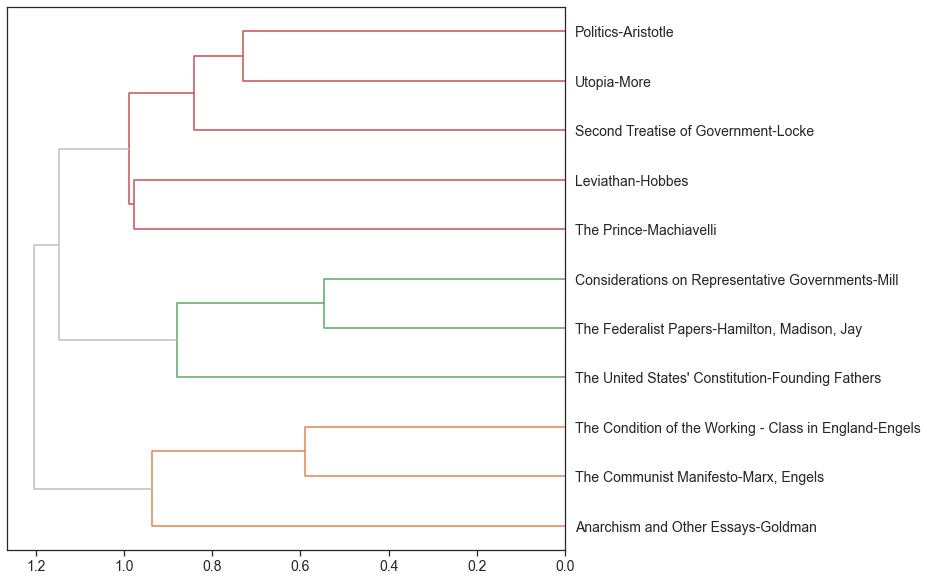

In [42]:
hca(PAIRS.cosine, color_thresh=1)

In [43]:
# hca(PAIRS.jaccard, color_thresh=1)

In [44]:
# hca(PAIRS.euclidean, color_thresh=1)

In [45]:
# hca(PAIRS.cityblock, color_thresh=1)

In [46]:
# hca(PAIRS.jensenshannon, color_thresh=1)

In [47]:
# hca(PAIRS.correlation, color_thresh=1)

In [48]:
# hca(PAIRS.dice, color_thresh=1)

### Cluster Results

The results of this clustering turned out better than I had expected. Some of the clustering methods proved inaccurate, but the cosine method (what we would assume works best by theory) perfromed a great clustering of the corpus of text. The cosine clustering actually identified three major clustering groups as apposed to two which I had originally assumed the clusters would return. The three cluster's we see under the cosine method seem to represent older western political philosophy, US political philosophy and documents, and Communist political philosophy. In addition, the cosine cluster successfully tied the US political philopophy cluster closer to the older western political philosophy which is what we would expect to see. It should be noted as well that the 'jensenshannon' method also produced good results and identified the three groups with US and Communist clusters closer together, but I ruled it out becuase there was not threashold color distinction between the groups and so cosine seemed the better fit. The new cluster's will look as follows:

Old_West:
"Politics" by Aristotle,
"Utopia" by More,
"Second Treatise of Government" by Hobbs,
"Leviathan" by Locke,
"The Prince" by Machiavelli,

US:
"Considerations on Representative Governments" by Mill,
"The Federalist Papers" by Hamilton, Madison, and Jay,
"The United States' Constitution" by the US Founding Fathers,

Communist:
"The Condition of the Working - Class in England" by Engles,
"The Communist Manifesto" by Marx, and Engels,
"Anarchism and Other Essays" by Goldman,


Next I will add these classificaitons to the LIB table and save it as Library.csv

In [49]:
# Add new cluster column to LIB table and rename it Library
cluster = ['Old_West', 'US', 'Communist', 'Old_West', 'Communist', 'Old_West', 'US', 'US', 'Communist', 'Old_West',
          'Old_West']
cluster_df = pd.DataFrame(
    {'book_id':book_id_list,
     'cluster' : cluster})
Library = pd.merge(LIB, cluster_df, on = "book_id")
Library

book_id                                       book_title  \
0      1232                The Prince, by Nicolo Machiavelli   
1      1404                        The Federalist Papers, by   
2     17306  The Condition of the Working - Class in England   
3      2130                           Utopia, by Thomas More   
4      2162      Anarchism and Other Essays, by Emma Goldman   
5      3207                      Leviathan, by Thomas Hobbes   
6         5                  The United States' Constitution   
7      5669  Considerations on Representative Government, by   
8        61                          The Communist Manifesto   
9      6762                           Politics, by Aristotle   
10     7370     Second Treatise of Government, by John Locke   

                  book_file                                            title  \
0    project_books/1232.txt                                       The Prince   
1    project_books/1404.txt                            The Federalist Papers   
2   project_books/17306.txt  The Condition of the Working - Class in England   
3    project_books/2130.txt                                           Utopia   
4    project_books/2162.txt                       Anarchism and Other Essays   
5    project_books/3207.txt                                        Leviathan   
6       project_books/5.txt                  The United States' Constitution   
7    project_books/5669.txt     Considerations on Representative Governments   
8      project_books/61.txt                          The Communist Manifesto   
9    project_books/6762.txt                                         Politics   
10   project_books/7370.txt                    Second Treatise of Government   

                    author    cluster  
0              Machiavelli   Old_West  
1   Hamilton, Madison, Jay         US  
2                   Engels  Communist  
3                     More   Old_West  
4                  Goldman  Communist  
5                   Hobbes   Old_West  
6         Founding Fathers         US  
7                     Mill         US  
8             Marx, Engels  Communist  
9                Aristotle   Old_West  
10                   Locke   Old_West

In [50]:
# Save Library
Library.to_csv('Library.csv')

## PCA

In [51]:
# Function for pre processing PCA - derive EIG_PAIRS, and TERM_IDX
def pca_processing(TFIDF_table):
    #Pre process TFIDF Matrix
    TFIDF_norm = TFIDF_table.apply(lambda x: x / norm(x), 1)
    TFIDF_norm = TFIDF_norm - TFIDF_norm.mean()
    
    #Compute Covariance Matrix
    COV = TFIDF_norm.cov()
    
    #Decompose the Matrix
    eig_vals, eig_vecs = eig(COV)
    TERM_IDX = COV.index 
    EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)
    EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
    EIG_VAL.index.name = 'term_id'
    
    #Eigen pair and explaind variance
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['variance'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
    
    return EIG_PAIRS, TERM_IDX

In [52]:
EIG_PAIRS, TERM_IDX = pca_processing(TFIDF_reduced)

In [53]:
# Create top components, loadings, and show PCO and PC1
def loadings(eig_pairs, term_idx, vocab_table):
    # Top 10 components
    Top = eig_pairs.sort_values('variance', ascending=False).head(10).reset_index(drop=True)
    Top.index.name = 'comp_id'
    Top.index = ["PC{}".format(x) for x in Top.index.tolist()]
    
    # Creating loadings
    loadings = Top[term_idx].T
    loadings.index.name = 'term_id'
    loadings['term_str'] = loadings.apply(lambda x: vocab_table.loc[int(x.name)].term_str, 1)
    
    # PC0 and PC1 loadings
    p0 = loadings.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
    n0 = loadings.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
    p1 = loadings.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
    n1 = loadings.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')
    return Top,loadings, p0, n0, p1, n1

In [54]:
Top,loadings, p0, n0, p1, n1 = loadings(EIG_PAIRS, TERM_IDX, VOCAB)
# Print out positive and negative PC0 and PC1 results 
print('Books PC0+', p0)
print('Books PC0-', n0)
print('Books PC1+', p1)
print('Books PC1-', n1)

Books PC0+ federal congress some sect oligarchy utopians legislature would constitutional electors
Books PC0- bourgeoisie bourgeois proletariat manchester workers class working operatives social factory
Books PC1+ congress federal local president legislature electors section constitutional national publius
Books PC1- castruccio utopians soveraign sect hath onely civill prince god florentines


In [113]:
loadings.to_csv("PCA.csv")

#### DCM table

In [55]:
# Create DCM table
def DCM_table(TFIDF_table, top, termidx, lib_table):
    lib = lib_table.set_index('book_id')
    lib = lib.sort_values('book_id')
    TFIDF_norm = TFIDF_table.apply(lambda x: x / norm(x), 1)
    TFIDF_norm = TFIDF_norm - TFIDF_norm.mean()
    DCM = TFIDF_norm.dot(Top[TERM_IDX].T)
    DCM['label'] = lib.cluster
    DCM['title'] = lib.title
    return DCM

In [56]:
DCM = DCM_table(TFIDF_reduced, Top,TERM_IDX, Library)
DCM.head()

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
book_id                                                                         
5       -0.234885 -0.451079 -0.535598 -0.016364 -0.278337 -0.337669  0.351526   
61       0.715419 -0.105710 -0.016338 -0.050799 -0.228676  0.093234 -0.066698   
1232    -0.053856  0.350184 -0.339997  0.798123  0.045398  0.127350 -0.155177   
1404    -0.348763 -0.521021  0.020708 -0.012293  0.000297  0.184151 -0.185586   
2130    -0.193460  0.357805  0.345476  0.008601 -0.179327 -0.101866  0.276636   

              PC7       PC8       PC9      label  \
book_id                                            
5       -0.042304  0.000393 -0.174329         US   
61      -0.046963 -0.505353  0.062905  Communist   
1232    -0.021468  0.015408  0.000283   Old_West   
1404     0.128465  0.048327  0.497130         US   
2130     0.604539 -0.089054 -0.011845   Old_West   

                                   title  
book_id                                   
5        The United States' Constitution  
61               The Communist Manifesto  
1232                          The Prince  
1404               The Federalist Papers  
2130                              Utopia

In [57]:
# This funtion was from code walkthrough and homework
# Creat function for PCA visulizations
def vis_pcs(M, a, b, prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color='label', 
                        hover_name='title', marginal_x='box')
    fig.show()

In [58]:
# Compairng PC0 and PC1
vis_pcs(DCM, 0, 1)

In [59]:
#Comparing PC1 and PC2
vis_pcs(DCM, 1, 2)

## Topic Modeling

In [60]:
# Create Topic Model OHCO
OHCO_TM = ['clusters', 'authors', 'book_id', 'chap_num', 'para_num']

#Create function to properly arrange Token table for topic modeling
def arrange_token(token_table, lib_table):
    LIB = lib_table.drop(columns = ['book_title', 'book_file', 'title'], axis = 1)
    token = token_table.reset_index()
    TOKENS = pd.merge(token, LIB, on='book_id')
    cluster = TOKENS['cluster']
    author = TOKENS['author']
    TOKENS.insert(loc=0, column='authors', value=author)
    TOKENS.insert(loc=0, column='clusters', value=cluster)
    TOKENS_TM = TOKENS.drop(columns = ['author', 'cluster'], axis = 1)
    TOKENS_TM = TOKENS_TM.set_index(OHCO_TM)
    return TOKENS_TM

In [61]:
TOKENS_TM = arrange_token(TOKEN, Library)
TOKENS_TM.head()

sent_num  token_num  \
clusters authors     book_id chap_num para_num                        
Old_West Machiavelli 1232    1        0                0          0   
                                      0                0          1   
                                      0                0          2   
                                      0                0          3   
                                      0                0          4   

                                                            pos_tuple  pos  \
clusters authors     book_id chap_num para_num                               
Old_West Machiavelli 1232    1        0             (CONCERNING, NNP)  NNP   
                                      0                    (NEW, NNP)  NNP   
                                      0         (PRINCIPALITIES, NNP)  NNP   
                                      0                  (WHICH, NNP)  NNP   
                                      0                    (ARE, NNP)  NNP   

                                                     token_str  \
clusters authors     book_id chap_num para_num                   
Old_West Machiavelli 1232    1        0             CONCERNING   
                                      0                    NEW   
                                      0         PRINCIPALITIES   
                                      0                  WHICH   
                                      0                    ARE   

                                                      term_str  term_id  
clusters authors     book_id chap_num para_num                           
Old_West Machiavelli 1232    1        0             concerning     5464  
                                      0                    new    15770  
                                      0         principalities    18099  
                                      0                  which    25045  
                                      0                    are     2532

In [62]:
# This code chunk comes from code walkthrough and homework
# Code compines all paragraphs into one string
TOKENS_TM['term_str'] = TOKENS_TM['term_str'].astype(str)
PARAS = TOKENS_TM[TOKENS_TM.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO_TM).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})
PARAS.head()

para_str
clusters  authors book_id chap_num para_num                                                   
Communist Engels  17306   1        1         order investigation sections proletariat histo...
                                   2         however moment proletariat movement condition ...
                                   3         manufacture property hands few capital colossa...
                                   4         centralising tendency manufacture here populat...
                                   5         commerce manufacture development influence pro...

In [63]:
# Function to create Topic Modeling Model
tfv = CountVectorizer(max_features=4000, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names()
def model(PARAS = PARAS, tf = tf, TERMS = TERMS):
    lda = LDA(n_components=25, max_iter=10, learning_offset=50., random_state=0)
    THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
    THETA.columns.name = 'topic_id'
    
    #PHI
    PHI = pd.DataFrame(lda.components_, columns=TERMS)
    PHI.index.name = 'topic_id'
    PHI.columns.name  = 'term_str'
    
    return THETA, PHI

In [64]:
THETA, PHI = model()
PHI.T.head().style.background_gradient()

In [65]:
# Create topics
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [66]:
TOPICS.head()

term_str             0           1           2          3         4         5  \
topic_id                                                                        
0                  men      people      person    opinion  election   persons   
1         consequences      people  government  elections   science      idea   
2                power  government     society       laws     state      sect   
3                  men      wealth         man      power      hath  subjects   
4               people  government      prince    country       war      king   

term_str        6          7        8         9  
topic_id                                         
0          office        man    power  electors  
1         history  qualities  example  pleasure  
2             man        law   nature     force  
3           thing   himselfe  actions    people  
4           state    nations  princes    nation

In [67]:
# Add label column to TOPICS table
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1)

# Set topics by Doc weight
TOPICS['doc_weight_sum'] = THETA.sum()

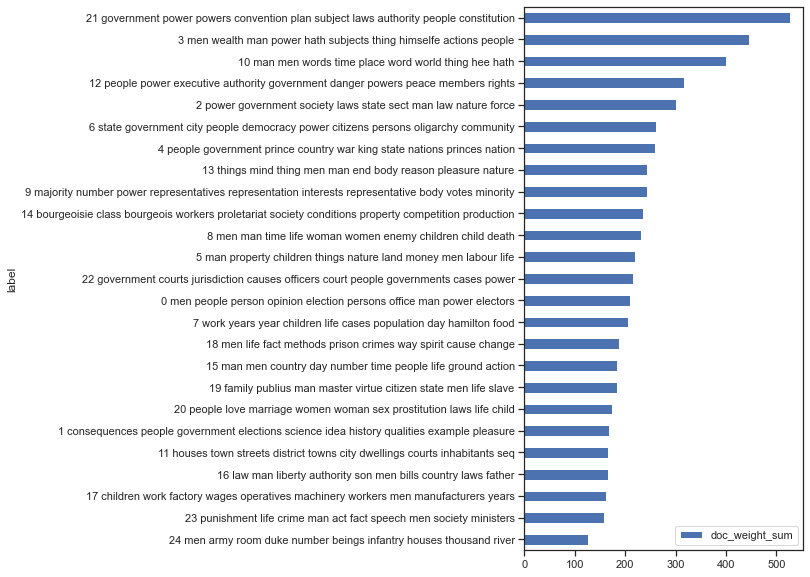

In [68]:
# Set topics by Doc weight
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

In [69]:
# Topics by book cluster given top 25 topics
topic_cols = [t for t in range(25)]
CLUSTERS = THETA.groupby('clusters')[topic_cols].mean().T                                            
CLUSTERS.index.name = 'topic_id'
CLUSTERS.T

topic_id         0         1         2         3         4         5   \
clusters                                                                
Communist  0.011878  0.029924  0.027422  0.012169  0.036010  0.023160   
Old_West   0.035754  0.021955  0.077483  0.144814  0.038304  0.060202   
US         0.050155  0.035894  0.026545  0.015098  0.055728  0.012097   

topic_id         6         7         8         9   ...        15        16  \
clusters                                           ...                       
Communist  0.011369  0.084697  0.055358  0.023389  ...  0.044586  0.029167   
Old_West   0.066115  0.011628  0.050467  0.014555  ...  0.038494  0.029009   
US         0.033781  0.031640  0.009466  0.091423  ...  0.008936  0.024397   

topic_id         17        18        19        20        21        22  \
clusters                                                                
Communist  0.078723  0.053552  0.035722  0.067239  0.015279  0.014357   
Old_West   0.012860  0.029439  0.024520  0.021565  0.018390  0.022099   
US         0.010470  0.018722  0.035825  0.012849  0.243652  0.071784   

topic_id         23        24  
clusters                       
Communist  0.041470  0.038752  
Old_West   0.025579  0.020675  
US         0.016536  0.008659  

[3 rows x 25 columns]

In [115]:
CLUSTERS.T.to_csv("Topic_model.csv")

In [70]:
CLUSTERS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [71]:
# Table with topics for Old_West cluster
CLUSTERS.sort_values('Old_West', ascending=False).style.background_gradient()

In [72]:
# Table with topics for US cluster
CLUSTERS.sort_values('US', ascending=False).style.background_gradient()

In [73]:
# Table with topics for Communist cluster
CLUSTERS.sort_values('Communist', ascending=False).style.background_gradient()

In [74]:
# This function comes from code walkthrough and homework
# Create cluster diagram of topics
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [75]:
# I kept the metric value consistent with 'cosine' as we did in the clustering section
SIMS = pdist(normalize(PHI), metric='cosine')
TREE = sch.linkage(SIMS, method='ward')

In [76]:
labels  = ["{}: {}".format(a,b) for a, b in zip(CLUSTERS.index,  CLUSTERS.topterms.tolist())]

<Figure size 432x288 with 0 Axes>

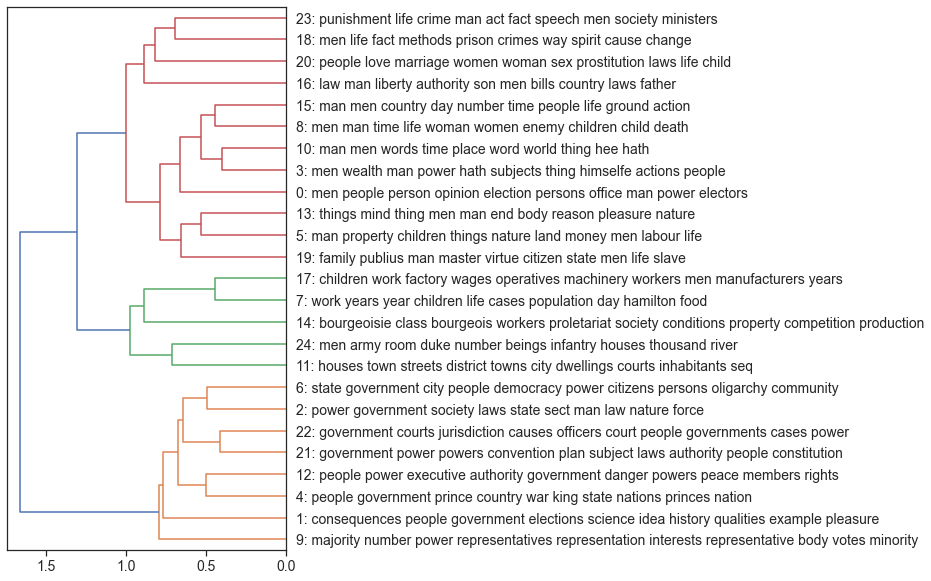

In [77]:
# Cluster plot
plot_tree(TREE, labels)

## Word Embedding

In [78]:
# Pre processing for Word Embedding
OHCO_WE = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
BAG_WE = OHCO[:3] # Paragraphs
TOKENS_WE  = TOKEN.reset_index()
window = 5

In [79]:
# lists of book_id's under each cluster
Old_West = [1232,2130,3207,6762,7370]
US = [1404,5,5669]
Communist = [17306,2162,61]

# Function that just creats the model
# Pass metrics for cluster name and min count for word2vec model
def model(cluster, min_count):
    # Split Token files by cluster
    TOKENS_cluster = TOKENS_WE[TOKENS_WE['book_id'].isin(cluster)]
    TOKENS_cluster = TOKENS_cluster.set_index(OHCO_WE)
    
    #Create corpus
    corpus_cluster = TOKENS_cluster[~TOKENS_cluster.pos.str.match('NNPS?')]\
        .groupby(BAG_WE)\
        .term_str.apply(lambda  x:  x.tolist())\
        .reset_index()['term_str'].tolist()

    #Create Model
    model = word2vec.Word2Vec(corpus_cluster, vector_size = 246, window=window, min_count=min_count, workers=4)
    return model

In [80]:
# Create word2vec models for future use
Old_West_model = model(Old_West, 100)
US_model = model(US, 100)
Communist_model = model(Communist, 50)

In [81]:
# Function to create word embedding cluster (includes the model as well)
# Pass two metrics the cluster you want and the min count for the model
def word_cluster(cluster, min_count):
    # Split Token files by cluster
    TOKENS_cluster = TOKENS_WE[TOKENS_WE['book_id'].isin(cluster)]
    TOKENS_cluster = TOKENS_cluster.set_index(OHCO_WE)
    
    #Create corpus
    corpus_cluster = TOKENS_cluster[~TOKENS_cluster.pos.str.match('NNPS?')]\
        .groupby(BAG_WE)\
        .term_str.apply(lambda  x:  x.tolist())\
        .reset_index()['term_str'].tolist()
    

    #Create Model
    model = word2vec.Word2Vec(corpus_cluster, vector_size = 246, window=window, min_count=min_count, workers=4)
    
    # Create coordinates
    coords_cluster = pd.DataFrame(index=range(len(model.wv.key_to_index)))
    coords_cluster['label'] = [w for w in model.wv.key_to_index]
    coords_cluster['vector'] = coords_cluster['label'].apply(lambda x: model.wv.get_vector(x))
    
    # Use TSNE library
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=25)
    tsne_values = tsne_model.fit_transform(coords_cluster['vector'].tolist())
    coords_cluster['x'] = tsne_values[:,0]
    coords_cluster['y'] = tsne_values[:,1]
    
    return coords_cluster

In [82]:
# Word embedding cluster for Old_West 
#Old_West_model = word_model(Old_West, 100)
Old_West_coords= word_cluster(Old_West, 100)
px.scatter(Old_West_coords, 'x', 'y', text='label', height=1000).update_traces(mode='text')

In [83]:
# Word embedding cluster for US 
US_coords = word_cluster(US, 100)
px.scatter(US_coords, 'x', 'y', text='label', height=1000).update_traces(mode='text')

In [84]:
# Word embedding cluster for Communist 
Communist_coords = word_cluster(Communist, 50)
px.scatter(Communist_coords, 'x', 'y', text='label', height=1000).update_traces(mode='text')

In [85]:
# Function to create analogy (slightly modified from version in walkthrough and homework)
# Pass two metrics the cluster you want and the min count for the model
def complete_analogy(cluster_model, A, B, C, n = 2):
    # Previously created module
    model = cluster_model
    # Does the analogy portion
    try:
        return model.wv.most_similar(positive=[B, C], negative=[A])[0:n]
    except KeyError as e:
        print('Error:', e)
        return None

In [86]:
complete_analogy(Old_West_model, 'government', 'law', 'man')

[('himselfe', 0.8274202942848206), ('himself', 0.7996671199798584)]

In [87]:
complete_analogy(US_model, 'government', 'law', 'man')

[('him', 0.9488282799720764), ('himself', 0.9337443113327026)]

In [88]:
complete_analogy(Communist_model, 'society', 'law', 'man')

[('self', 0.9665583968162537), ('day', 0.9571138024330139)]

In [89]:
complete_analogy(US_model, 'citizens', 'state', 'legislative')

[('authority', 0.9686020612716675), ('executive', 0.9485326409339905)]

In [90]:
complete_analogy(Communist_model, 'man', 'women', 'proletariat')

[('workers', 0.9775561094284058), ('all', 0.9638038873672485)]

In [91]:
# Model to find most similar words
def most_similar(model, word):
    print(model.wv.most_similar(word))

In [92]:
most_similar(Old_West_model, 'power')

[('over', 0.8021767735481262), ('right', 0.7746569514274597), ('legislative', 0.7708926200866699), ('property', 0.7586935758590698), ('authority', 0.7576982975006104), ('life', 0.7439900636672974), ('father', 0.7229859232902527), ('supreme', 0.6884879469871521), ('liberty', 0.6787075400352478), ('hands', 0.6760217547416687)]


In [93]:
most_similar(US_model, 'power')

[('constitution', 0.9473392367362976), ('legislature', 0.943340539932251), ('authority', 0.9393161535263062), ('federal', 0.9352997541427612), ('part', 0.9235583543777466), ('principle', 0.9206650853157043), ('mode', 0.9203547835350037), ('first', 0.9152889847755432), ('jurisdiction', 0.9146530032157898), ('general', 0.9137412905693054)]


In [94]:
most_similar(Communist_model, 'power')

[('modern', 0.999068021774292), ('movement', 0.9986710548400879), ('first', 0.9985448718070984), ('form', 0.9985138773918152), ('being', 0.9981505274772644), ('part', 0.9980900287628174), ('consequence', 0.9978486895561218), ('general', 0.9977990388870239), ('report', 0.9976047277450562), ('population', 0.9975407123565674)]


## Sentiment Analysis

In [95]:
# Preprocessing for sentiment analysis
OHCO_SA = ['book', 'book_id', 'chap_num', 'para_num', 'sent_num']
CHAPS = OHCO_SA[2:3]
PARAS = OHCO_SA[2:4]
SENTS = OHCO_SA[2:5]

# Loading in the NRC emotions
salex_csv = 'salex_nrc.csv'
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
emo = 'polarity'

In [96]:
# Get lexicon and lexicon columns
salex = pd.read_csv(salex_csv).set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]
salex['polarity'] = salex.positive - salex.negative
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()
emo_cols 

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust',
 'polarity']

#### Get Novels

In [97]:
# Create TOKEN table for Sentiment analysis and join with NRC emotions
def create_SA_token(Token_table, OHCO_SA = OHCO_SA):
    TOKENS_SA = Token_table.reset_index()
    Tok = TOKENS_SA.merge(Library[['book_id','title']], on = 'book_id', how = 'right')
    book = Tok['title']
    Tok.insert(loc=0, column='book', value=book)
    Tok = Tok.drop(columns = 'title')
    TOKENS_SA = Tok.set_index(OHCO_SA).sort_index()
    TOKENS_SA.head()
    TOKENS_SA = TOKENS_SA.join(salex, on='term_str', how='left')
    TOKENS_SA[emo_cols] = TOKENS_SA[emo_cols].fillna(0)
    TOKENS_SA[['term_str'] + emo_cols].sample(10)
    TOKENS_SA[emo_cols] = TOKENS_SA[emo_cols].fillna(0)
    return TOKENS_SA

In [98]:
TOKENS_SA = create_SA_token(TOKEN)
TOKENS_SA.sample(10)

token_num  \
book                                            book_id chap_num para_num sent_num              
Leviathan                                       3207    27       58       0                44   
The Condition of the Working - Class in England 17306   2        50       4                22   
The Communist Manifesto                         61      1        47       0                50   
The Condition of the Working - Class in England 17306   7        8        40               84   
Considerations on Representative Governments    5669    11       1        6                75   
Politics                                        6762    13       1        9               165   
                                                        92       1        13                3   
Leviathan                                       3207    24       25       1                 5   
Anarchism and Other Essays                      2162    11       23       1                 4   
The Federalist Papers                           1404    37       13       8                12   

                                                                                            pos_tuple  \
book                                            book_id chap_num para_num sent_num                      
Leviathan                                       3207    27       58       0                 (and, CC)   
The Condition of the Working - Class in England 17306   2        50       4             (without, IN)   
The Communist Manifesto                         61      1        47       0                (sway, NN)   
The Condition of the Working - Class in England 17306   7        8        40            (certain, JJ)   
Considerations on Representative Governments    5669    11       1        6                 (who, WP)   
Politics                                        6762    13       1        9           (consists, VBZ)   
                                                        92       1        13          (naturally, RB)   
Leviathan                                       3207    24       25       1             (setled,, JJ)   
Anarchism and Other Essays                      2162    11       23       1               (his, PRP$)   
The Federalist Papers                           1404    37       13       8         (themselves,, NN)   

                                                                                     pos  \
book                                            book_id chap_num para_num sent_num         
Leviathan                                       3207    27       58       0           CC   
The Condition of the Working - Class in England 17306   2        50       4           IN   
The Communist Manifesto                         61      1        47       0           NN   
The Condition of the Working - Class in England 17306   7        8        40          JJ   
Considerations on Representative Governments    5669    11       1        6           WP   
Politics                                        6762    13       1        9          VBZ   
                                                        92       1        13          RB   
Leviathan                                       3207    24       25       1           JJ   
Anarchism and Other Essays                      2162    11       23       1         PRP$   
The Federalist Papers                           1404    37       13       8           NN   

                                                                                      token_str  \
book                                            book_id chap_num para_num sent_num                
Leviathan                                       3207    27       58       0                 and   
The Condition of the Working - Class in England 17306   2        50       4             without   
The Communist Manifesto                         61      1        47       0                sway   
The Condition of the Working - Class in England 17306   7 

In [117]:
TOKENS_SA.to_csv("Sentiment_Analysis.csv")

In [99]:
# Copy Sentiment Analysis token table for specific books
Fed = TOKENS_SA.loc['The Federalist Papers'].copy()
Prince = TOKENS_SA.loc['The Prince'].copy()
Condition = TOKENS_SA.loc['The Condition of the Working - Class in England'].copy()

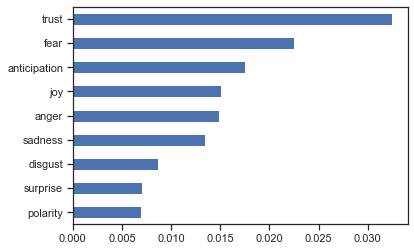

In [100]:
# Bar Graph of emotions and polarity of the Federalist Papers
Fed[emo_cols].mean().sort_values().plot.barh()

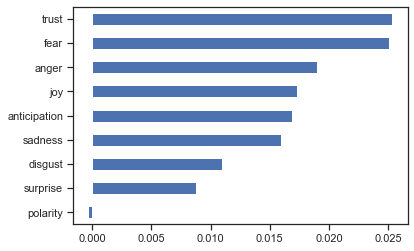

In [101]:
# Bar Graph of emotions and polarity of The Prince
Prince[emo_cols].mean().sort_values().plot.barh()

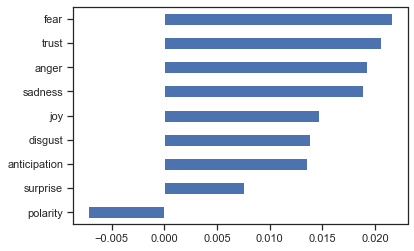

In [102]:
# Bar Graph of emotions and polarity of The Condition of the Working - Class in England
Condition[emo_cols].mean().sort_values().plot.barh()

In [103]:
# Group the three books by their Chapters
Fed_chaps = Fed.groupby(CHAPS)[emo_cols].mean()
Prince_chaps = Prince.groupby(CHAPS)[emo_cols].mean()
Condition_chaps = Condition.groupby(CHAPS)[emo_cols].mean()

In [104]:
# This function comes from Code Walthrough and homework
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

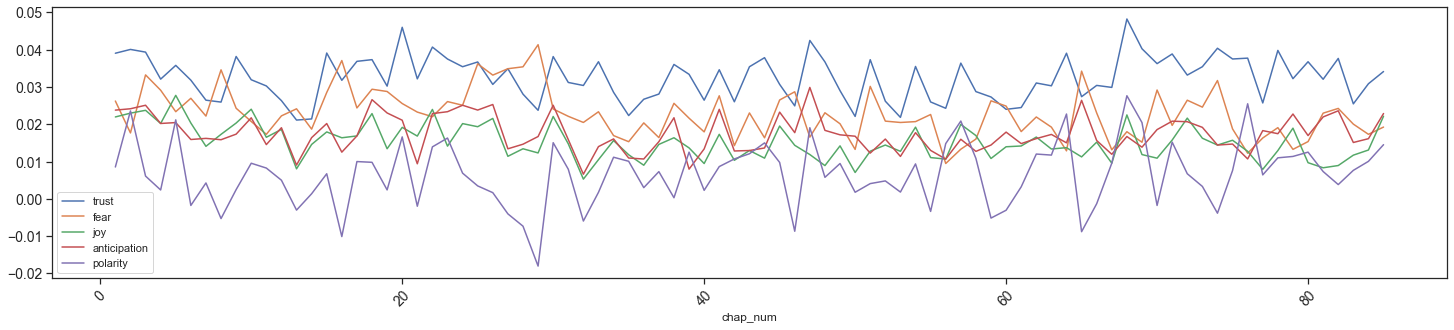

In [105]:
# plot of sentiments for Federalist papers
plot_sentiments(Fed_chaps, ['trust','fear','joy','anticipation', 'polarity'])

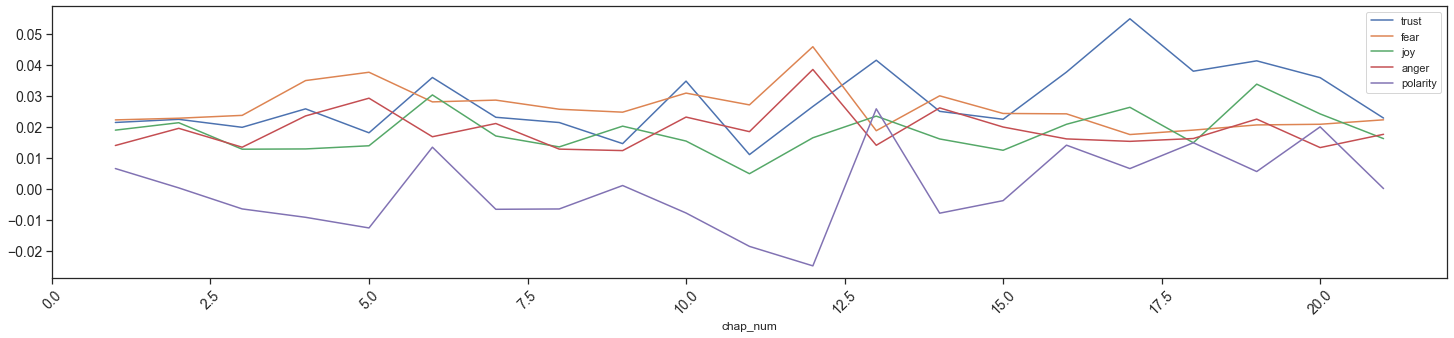

In [106]:
# plot of sentiments for The Prince
plot_sentiments(Prince_chaps, ['trust','fear','joy','anger','polarity'])

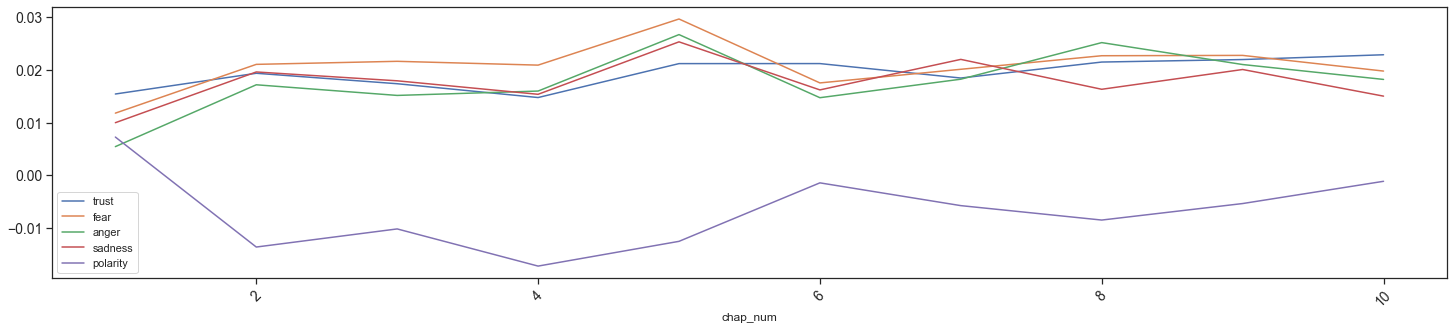

In [107]:
# plot of sentiments fot The Condition of the Working - Class in England
plot_sentiments(Condition_chaps, ['trust','fear','anger','sadness','polarity'])

Based on these resulsts we can see that 'The Federalist Papers' seemed to have a positive polarity due to it's polairty value greater than 0.005, 'The Prince' seemed to be about neutral, and 'The Condition of the Working - Class in England' seemed to have negative polairty given its value of less than -0.005. Based my personal understanding of the text this makes sense to me given that the authors of 'The Federalist Papers' were trying to spread their political philiophy in a positive way to make people happy with the idea of the US Constitution and vote to ratify it. On the other hand, 'The Condition of the Working - Class in England' attempted to make people angry and go about political change through anger.

#### Vader

In [108]:
# Creat function to be able to Run vader on specific book's sentiment analysis token table 
analyser = SentimentIntensityAnalyzer()
def vadar(book_tokens):
    book_tokens['html'] =  book_tokens.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
    Book_sents = book_tokens.groupby(SENTS)[emo_cols].mean()
    Book_sents['sent_str'] = book_tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
    Book_sents['html_str'] = book_tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))
    Book_vader_cols = Book_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
    Book_vader = pd.concat([Book_sents, Book_vader_cols], axis=1)
    w = int(Book_vader.shape[0] / 5)
    Book_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5))
    Book_vader[['neu']].rolling(w).mean().plot(figsize=(25,5))
    Book_vader[['compound']].rolling(w).mean().plot(figsize=(25,5))

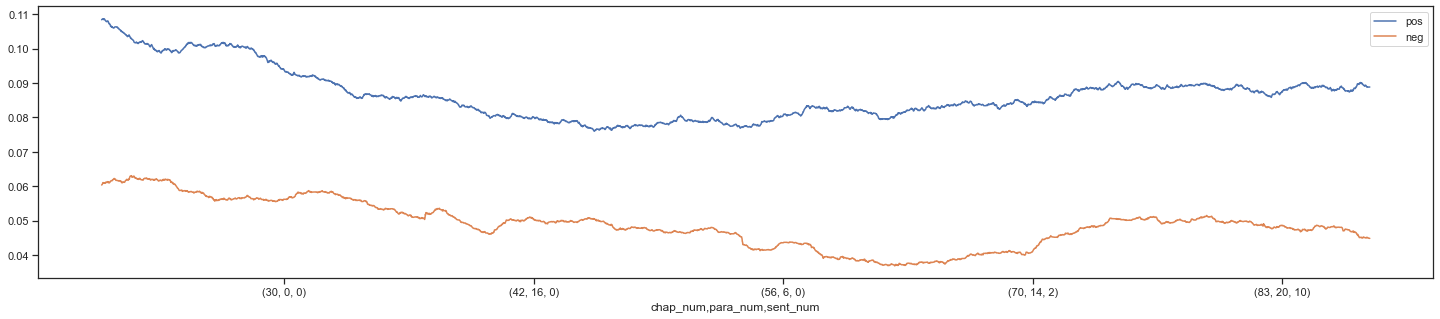

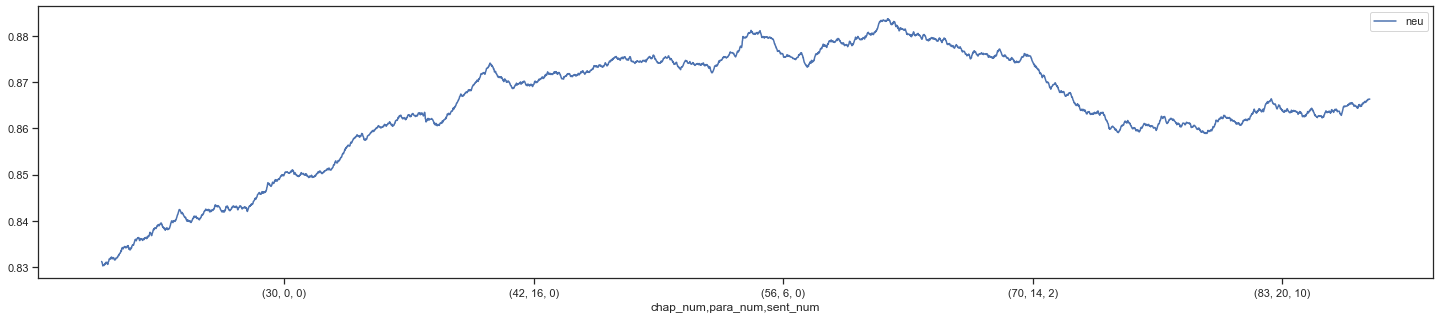

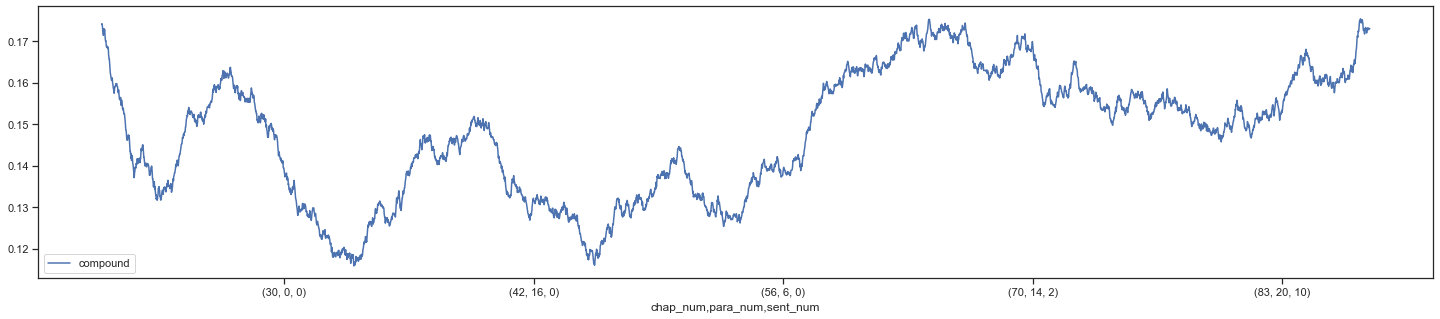

In [109]:
# Vard done on the Federalist Papers
vadar(Fed)

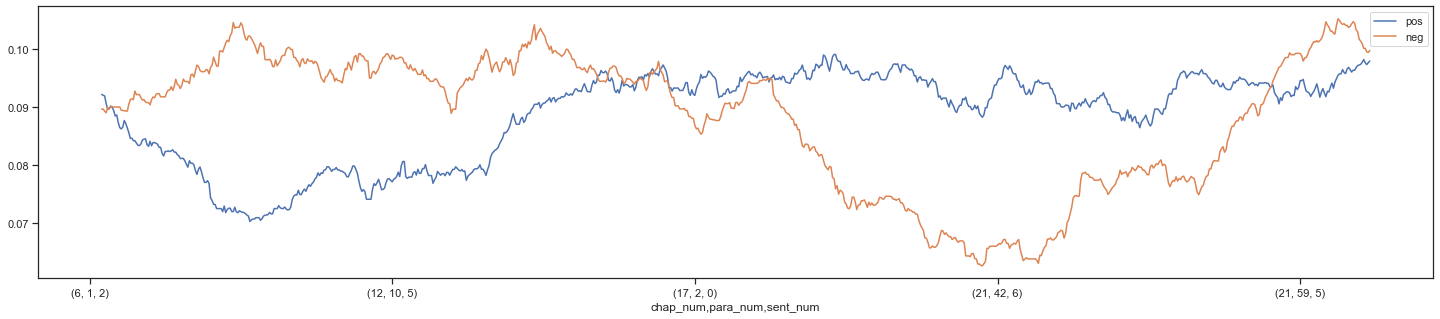

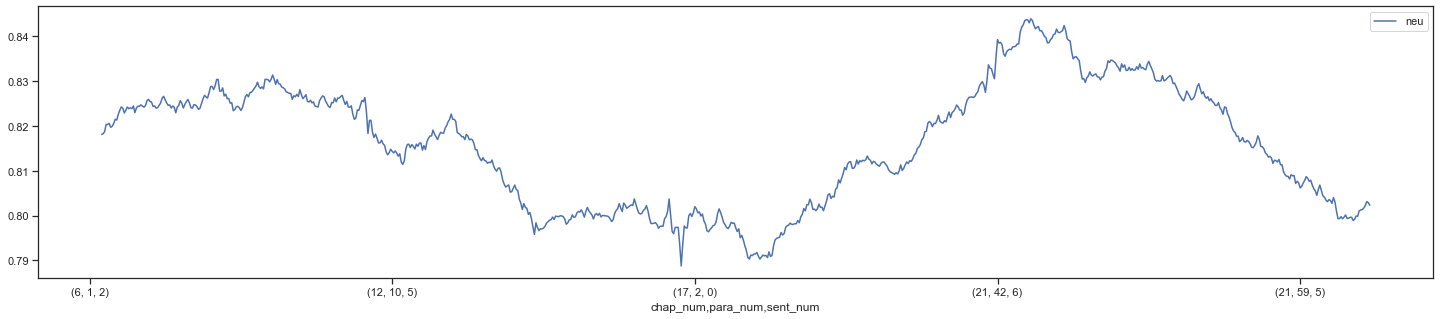

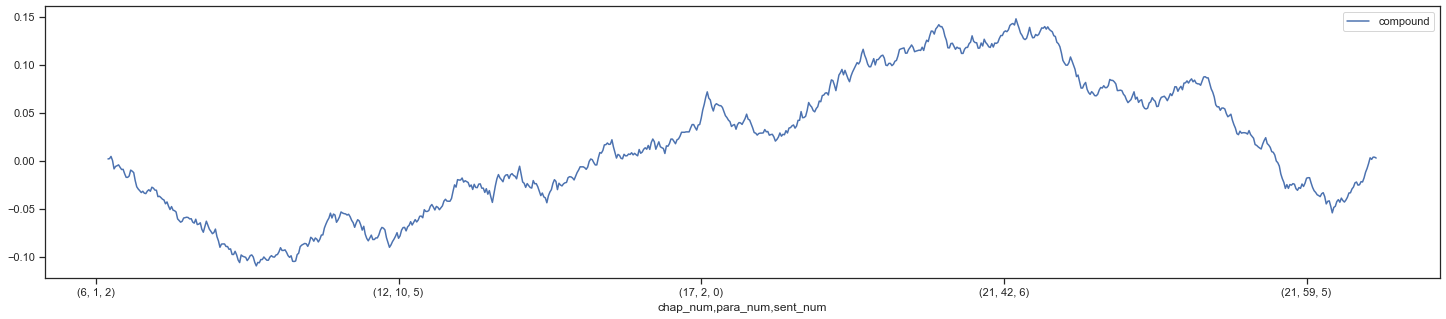

In [110]:
# Vadar done on Prince
vadar(Prince)

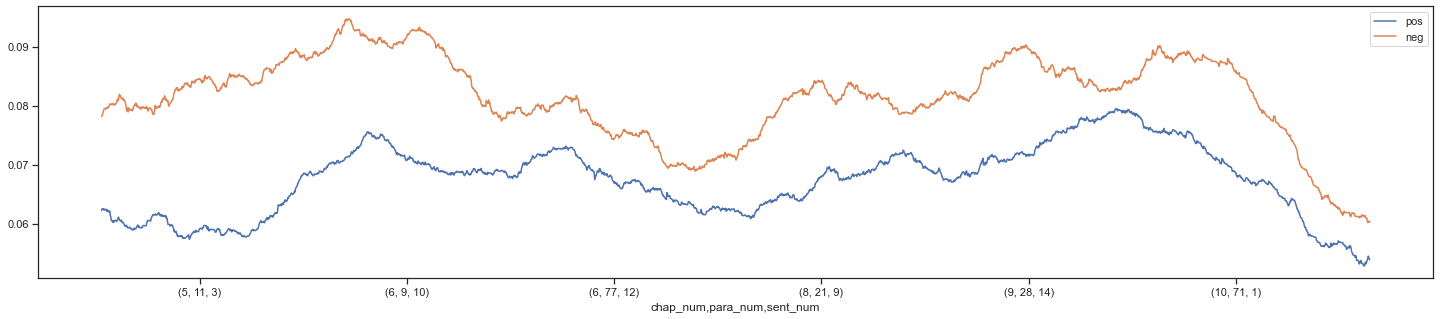

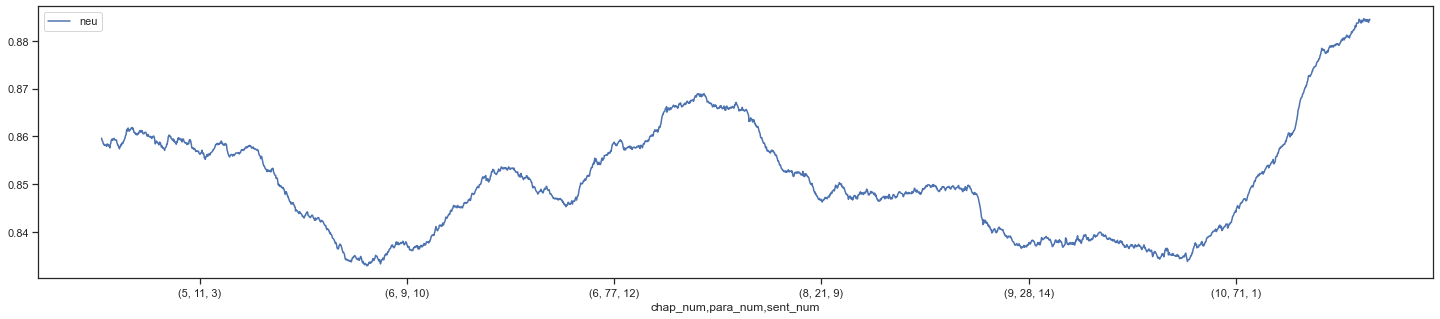

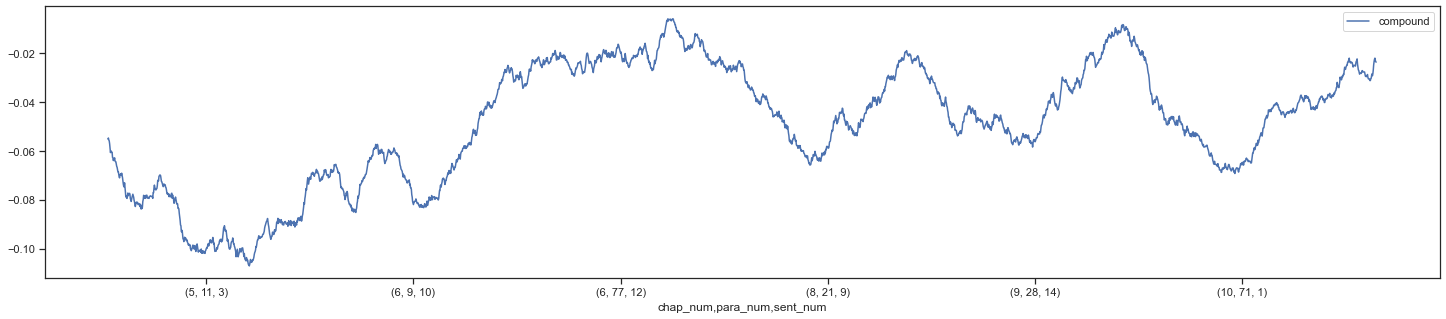

In [111]:
#Vadar done on conditions of working class in England
vadar(Condition)

The Vader method seems to lend further evidence to the point made about the sentiments. 'The Federalist Papers' show that positive polarity is higher than negative. "The Price" shows the polarities going back and forth which is about neutral, and "The Condition of the Working - Class in England" shows negative polarity higher than positive polarity.